# Transformer 예제
* 임의의 퓨리에 급수 생성하여 학습한 후 Transformer로 예측

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import trange

# 시드 설정, for reproducibility
# torch.manual_seed(42)
# np.random.seed(42)

1. 퓨리에 급수를 사용한 시계열 데이터 생성

In [44]:
def generate_fourier_series(n_samples=2000, dt=0.01):
    """
    임의의 퓨리에 급수를 사용하여 시계열 데이터 생성
    f(t) = a0 + sum(an*cos(n*w*t) + bn*sin(n*w*t))
    """
    t = np.arange(0, n_samples * dt, dt)
    
    # 기본 주기, 주파수 설정
    T = np.random.uniform(5, 15) 
    print(f'주기 T={T:.4f}')
    w = 2 * np.pi / T
    print(f'기본 주파수 w={w:.4f}')
    
    # 퓨리에 계수들 (임의로 설정)
    a0 = np.random.rand() * 10  # DC 성분 ( -10, 10)
    coefficients = np.random.randn(5, 2) * 2  # (an, bn) 쌍을 임의로 생성
    
    # 퓨리에 급수 계산
    signal = np.full_like(t, a0)
    
    for n, (an, bn) in enumerate(coefficients, 1):
        signal += an * np.cos(n * w * t) + bn * np.sin(n * w * t)
    
    # 약간의 노이즈 추가
    noise = np.random.normal(0, 0.2, len(signal))
    signal += noise
    
    return signal, t

주기 T=6.9815
기본 주파수 w=0.9000


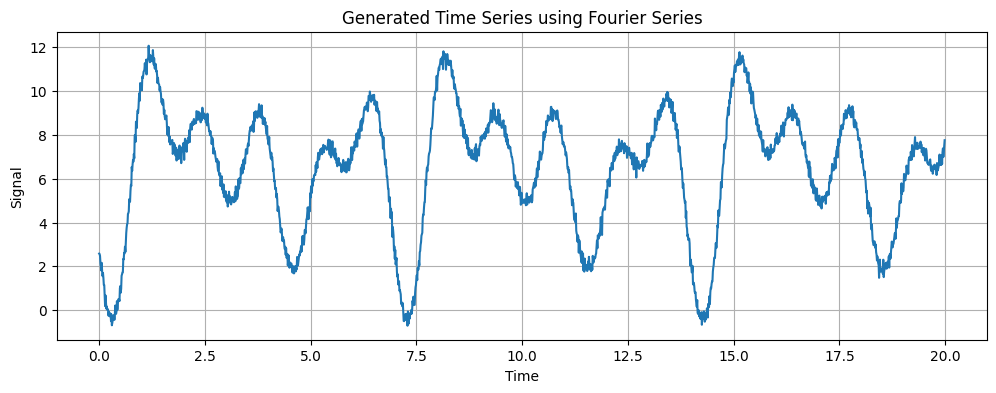

In [45]:
plt.figure(figsize=(12, 4))
signal, t = generate_fourier_series()
plt.plot(t, signal)
plt.title("Generated Time Series using Fourier Series")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.grid()
plt.show()

2. 시계열 데이터셋 클래스

In [46]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, pred_length):
        super().__init__() # Dataset 초기화 코드는 필요없으나, 향후 확장성을 위해 추가
        self.data = data
        self.seq_length = seq_length
        self.pred_length = pred_length
        
    def __len__(self):
        return len(self.data) - self.seq_length - self.pred_length + 1
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length:idx + self.seq_length + self.pred_length]
        return torch.FloatTensor(x).unsqueeze(-1), torch.FloatTensor(y).unsqueeze(-1)

In [47]:
signal, time_points = generate_fourier_series(n_samples=100)
print(f'signal.shape={signal.shape}, time_points.shape={time_points.shape}')
print(signal[:10])

train_dataset = TimeSeriesDataset(signal, 10, 5)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)
print(f'len(train_dataset)={len(train_dataset)}')
print(f'len(train_loader)={len(train_loader)}')
tmp_data = next(iter(train_loader))
print(f'tmp_data type={type(tmp_data)}, len(tmp_data)={len(tmp_data)}')
print(f'type(tmp_data[0])={type(tmp_data[0])}, type(tmp_data[1])={type(tmp_data[1])}')
print(f'tmp_data[0].shape={tmp_data[0].shape}, tmp_data[1].shape={tmp_data[1].shape}')


주기 T=9.2524
기본 주파수 w=0.6791
signal.shape=(100,), time_points.shape=(100,)
[5.02222412 4.898449   5.00182582 4.67786394 4.55935712 5.07116212
 4.92723609 5.00466008 5.1396725  4.79398799]
len(train_dataset)=86
len(train_loader)=18
tmp_data type=<class 'list'>, len(tmp_data)=2
type(tmp_data[0])=<class 'torch.Tensor'>, type(tmp_data[1])=<class 'torch.Tensor'>
tmp_data[0].shape=torch.Size([5, 10, 1]), tmp_data[1].shape=torch.Size([5, 5, 1])


3. 위치 인코딩
* 위치 인코딩 vector는 전체 모델에서 상수로 사용되며, 학습 대상이 아님
* 따라서, Buffer 로 저장
* Buffer
    * state_dict에 포함되며, 모델 저장 및 로드 시 함께 저장됨
    * 모델의 파라미터가 아니므로 optimizer의 업데이트 대상이 되지 않음
    * 이는 모델의 구조적 일부이지만 학습 과정에서 변경되지 않는 값들을 저장하는 데 유용함
    * 예: 학습되지 않는 임베딩, 정규화 통계 등
    * register_buffer() 를 사용하면 모델의 이동(device 이동 등) 시에도 자동으로 이동됨
    * 따라서 모델의 일관성을 유지하는 데 도움이 됨
    * 모델의 일부로서 저장 및 로드가 필요하지만 학습되지 않는 값들을 관리하는 데 유용함
    * Parameter와 달리 requires_grad=False로 설정됨

In [48]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, batch_first=False):
        super().__init__()
        
        self.batch_first = batch_first

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # batch_first에 따라 다른 shape으로 저장
        # 트랜스포머 모듈에서 batch_first 옵션을 사용할 수 있기 때문, 기본값은 False
        if batch_first:
            pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        else:
            pe = pe.transpose(0, 1).unsqueeze(0)  # [max_len, 1, d_model]
        
        self.register_buffer('pe', pe) # 학습되지 않는 버퍼로 등록, 모델의 일부이지만 학습되지 않음
    
    def forward(self, x):
        if self.batch_first:
            return x + self.pe[:, :x.size(1), :]  # batch 차원 고려, x.shape = [batch, seq, feature]
        else:
            return x + self.pe[:x.size(0), :, :]  # sequence 차원 고려, x.shape = [seq, batch, feature]


pos_encoding.pe.shape=torch.Size([1, 100, 32])
tensor(0.)
out.shape=torch.Size([1, 100, 32])
pe.shape=(100, 32)


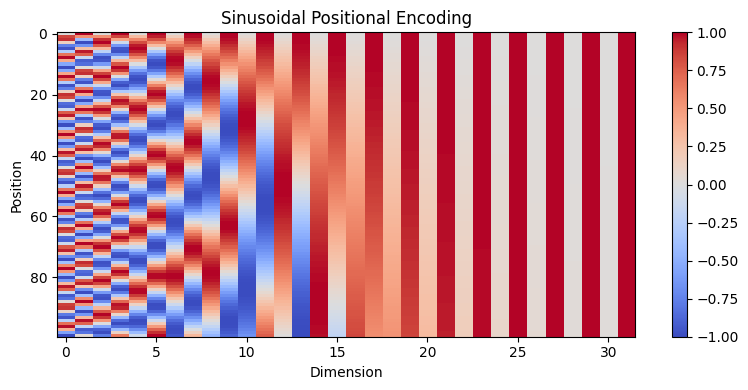

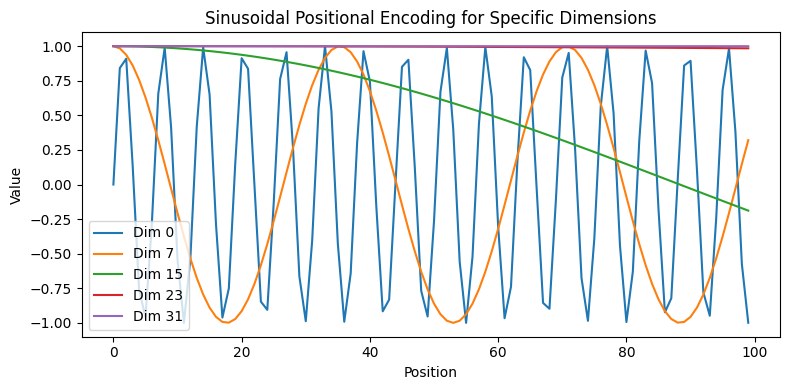

In [49]:
max_position = 100  # Maximum sequence length
d_model = 32        # Embedding dimension

pos_encoding = PositionalEncoding(d_model, max_position, batch_first=True)
print(f'pos_encoding.pe.shape={pos_encoding.pe.shape}')
print(pos_encoding.pe[0, 0, 0])
x = np.zeros((1, max_position, d_model))  # (batch, seq, feature)
x = torch.FloatTensor(x)
out = pos_encoding(x)
print(f'out.shape={out.shape}')

# 시각화
pe = pos_encoding.pe.squeeze().numpy()
print(f'pe.shape={pe.shape}')
plt.figure(figsize=(8, 4))
plt.imshow(pe, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Sinusoidal Positional Encoding')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
dimensions = np.linspace(0, d_model - 1, num=5, dtype=int)
#dimensions = np.arange(0, d_model, step=2)
for d in dimensions:
    plt.plot(pe[:, d], label=f'Dim {d}')
plt.legend()
plt.title('Sinusoidal Positional Encoding for Specific Dimensions')
plt.xlabel('Position')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

4. Transformer 시계열 예측 모델

In [50]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=8, num_layers=3, 
                 seq_length=100, pred_length=20, dropout=0.1, batch_first=True):
        super(TimeSeriesTransformer, self).__init__()
        
        self.d_model = d_model
        self.seq_length = seq_length
        self.pred_length = pred_length
        self.batch_first = batch_first
        
        # 입력 임베딩
        self.input_embedding = nn.Linear(input_dim, d_model)
        
        # 위치 인코딩
        self.pos_encoding = PositionalEncoding(d_model, max_len=seq_length, batch_first=batch_first)
        
        # Transformer 인코더
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=batch_first
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # 출력 레이어
        self.output_projection = nn.Linear(d_model, pred_length * input_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim) if batch_first=True
        batch_size = x.size(0)
        
        # 입력 임베딩
        x = self.input_embedding(x) * math.sqrt(self.d_model)
        
        # 위치 인코딩 (transpose for positional encoding)
        x = self.pos_encoding(x)
        
        # Transformer 인코딩
        x = self.transformer_encoder(x)
        
        # 마지막 타임스텝의 출력을 사용
        if self.batch_first:
            x = x[:, -1, :]  # (batch_size, d_model)
        else:
            x = x[-1, :, :]  # (batch_size, d_model)
        
        # 예측값 생성
        output = self.output_projection(x)  # (batch_size, pred_length * input_dim)
        output = output.view(batch_size, self.pred_length, 1)
        
        return output


5. 훈련 함수

In [51]:
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, device=None):
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
    
    train_losses = []
    val_losses = []
    
    for epoch in trange(epochs):
        # 훈련
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # 검증
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                val_loss += criterion(output, batch_y).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    return train_losses, val_losses

6. 예측 함수

In [52]:
def predict_future(model, data, seq_length, pred_steps, device):
    """미래 값을 단계별로 예측"""
    model.eval()
    predictions = []
    
    # 초기 시퀀스
    current_seq = torch.FloatTensor(data[-seq_length:]).unsqueeze(0).unsqueeze(-1).to(device)
    
    with torch.no_grad():
        for _ in range(pred_steps):
            # 한 스텝 예측
            pred = model(current_seq)
            next_value = pred[:, 0, :].cpu().numpy()[0, 0]  # 첫 번째 예측값만 사용
            predictions.append(next_value)
            
            # 시퀀스 업데이트 (새로운 값 추가, 가장 오래된 값 제거)
            next_value_tensor = torch.FloatTensor([[[next_value]]]).to(device)
            #print(f'current_seq.shape={current_seq.shape}')
            #print(f'next_value_tensor.shape={next_value_tensor.shape}')
            current_seq = torch.cat([current_seq[:, 1:, :], next_value_tensor], dim=1)
    
    return predictions

퓨리에 급수 데이터 생성 중...
주기 T=6.1872
기본 주파수 w=1.0155
Transformer 모델 생성 중...
모델 파라미터 수: 150,730
모델 훈련 시작...
사용 디바이스: mps


 33%|███▎      | 10/30 [00:10<00:20,  1.00s/it]

Epoch 10/30, Train Loss: 0.009480, Val Loss: 0.008354


 67%|██████▋   | 20/30 [00:20<00:09,  1.01it/s]

Epoch 20/30, Train Loss: 0.008957, Val Loss: 0.007789


100%|██████████| 30/30 [00:30<00:00,  1.01s/it]

Epoch 30/30, Train Loss: 0.006026, Val Loss: 0.005043
미래 값 예측 중...


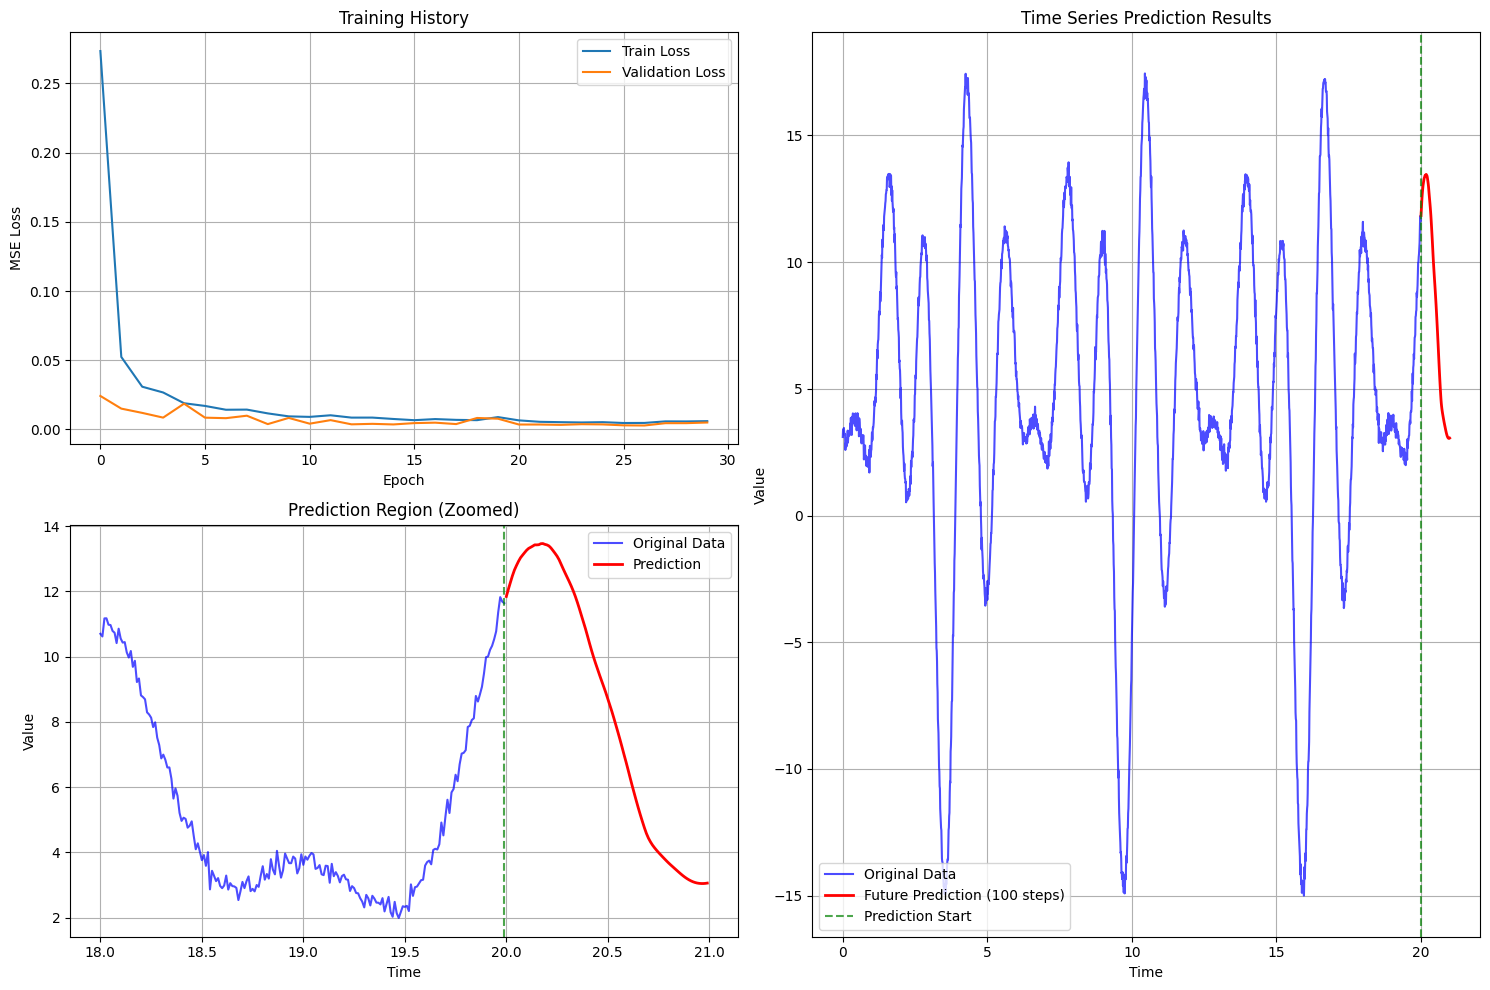


=== 훈련 완료 ===
최종 훈련 손실: 0.006026
최종 검증 손실: 0.005043
예측된 미래 100개 스텝의 평균: 8.4337
예측된 미래 100개 스텝의 표준편차: 3.9972


In [53]:
# 7. 메인 실행 코드
if __name__ == "__main__":
    # 하이퍼파라미터
    SEQ_LENGTH = 100  # 입력 시퀀스 길이
    PRED_LENGTH = 10 #20  # 예측 길이 (훈련 시)
    FUTURE_STEPS = 100  # 미래 예측 스텝
    BATCH_SIZE = 32
    EPOCHS = 30
    
    # 1. 데이터 생성
    print("퓨리에 급수 데이터 생성 중...")
    signal, time_points = generate_fourier_series(n_samples=2000)
    
    # 2. 데이터 정규화
    mean = np.mean(signal)
    std = np.std(signal)
    signal_normalized = (signal - mean) / std
    
    # 3. 훈련/검증 데이터 분할
    train_size = int(0.8 * len(signal_normalized))
    train_data = signal_normalized[:train_size]
    val_data = signal_normalized[train_size-SEQ_LENGTH:]  # 연속성을 위해 겹침
    
    # 4. 데이터셋 및 데이터로더 생성
    train_dataset = TimeSeriesDataset(train_data, SEQ_LENGTH, PRED_LENGTH)
    val_dataset = TimeSeriesDataset(val_data, SEQ_LENGTH, PRED_LENGTH)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # 5. 모델 생성
    print("Transformer 모델 생성 중...")
    model = TimeSeriesTransformer(
        input_dim=1,
        d_model=64,
        nhead=8,
        num_layers=3,
        seq_length=SEQ_LENGTH,
        pred_length=PRED_LENGTH
    )
    
    print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
    
    # 6. 모델 훈련
    print("모델 훈련 시작...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = 'mps' if torch.backends.mps.is_available() else device
    print(f"사용 디바이스: {device}")
    
    train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=EPOCHS, device=device)
    
    # 7. 미래 예측
    print("미래 값 예측 중...")
    future_predictions = predict_future(
        model, signal_normalized, SEQ_LENGTH, FUTURE_STEPS, device
    )
    
    # 정규화 해제
    future_predictions = np.array(future_predictions) * std + mean
    
    # 8. 결과 시각화
    plt.figure(figsize=(15, 10))
    
    # 손실 그래프
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    
    # 원본 데이터와 예측 결과
    plt.subplot(2, 2, (2, 4))
    
    # 원본 데이터
    plt.plot(time_points, signal, 'b-', label='Original Data', alpha=0.7)
    
    # 예측 시작점
    prediction_start_idx = len(signal)
    prediction_time = np.arange(
        time_points[-1] + (time_points[1] - time_points[0]),
        time_points[-1] + (time_points[1] - time_points[0]) * (FUTURE_STEPS + 1),
        time_points[1] - time_points[0]
    )
    
    # 미래 예측
    plt.plot(prediction_time, future_predictions, 'r-', 
             label=f'Future Prediction ({FUTURE_STEPS} steps)', linewidth=2)
    
    # 연결점 표시
    plt.axvline(x=time_points[-1], color='g', linestyle='--', alpha=0.7, label='Prediction Start')
    
    plt.title("Time Series Prediction Results")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    # 확대된 예측 구간
    plt.subplot(2, 2, 3)
    # 마지막 200개 원본 데이터점과 예측 결과
    plt.plot(time_points[-200:], signal[-200:], 'b-', label='Original Data', alpha=0.7)
    plt.plot(prediction_time, future_predictions, 'r-', 
             label='Prediction', linewidth=2)
    plt.axvline(x=time_points[-1], color='g', linestyle='--', alpha=0.7)
    plt.title('Prediction Region (Zoomed)')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 9. 성능 평가
    print("\n=== 훈련 완료 ===")
    print(f"최종 훈련 손실: {train_losses[-1]:.6f}")
    print(f"최종 검증 손실: {val_losses[-1]:.6f}")
    print(f"예측된 미래 {FUTURE_STEPS}개 스텝의 평균: {np.mean(future_predictions):.4f}")
    print(f"예측된 미래 {FUTURE_STEPS}개 스텝의 표준편차: {np.std(future_predictions):.4f}")